<a href="https://colab.research.google.com/github/andythetechnerd03/PyTorch_Learning/blob/main/Deep_Learning_with_PyTorch_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM - Gradient Class Activation Map

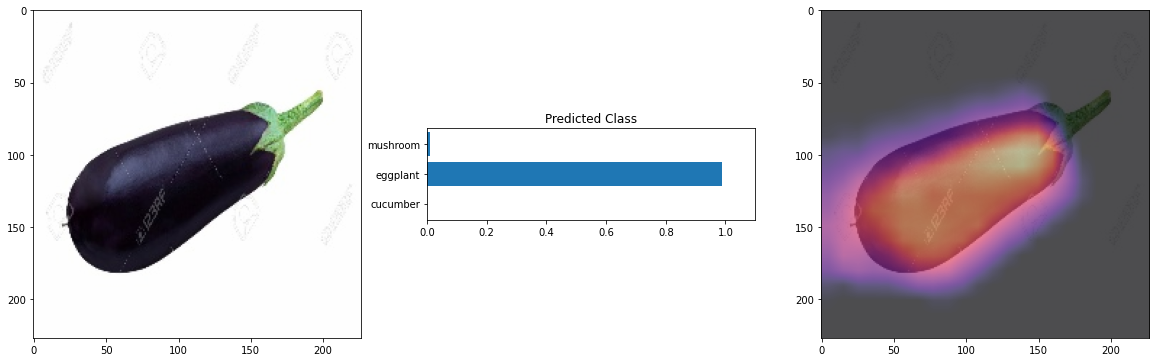

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 9.74 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-0_um2xc8
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-0_um2xc8
  Resolved https://github.com/albumentations-team/albumentations to commit a4857abf09c472088ddd3efbe2c690a1189bce3e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/3

# Imports

In [2]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [6]:
CSV_FILE = "/content/GradCAM-Dataset/train.csv"
DATA_DIR = "/content/GradCAM-Dataset/"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20
DEVICE

'cpu'

In [7]:
data = pd.read_csv(CSV_FILE)
data

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1
...,...,...
181,train_images/eggplant_62.jpg,1
182,train_images/cucumber_45.jpg,0
183,train_images/mushroom_37.jpg,2
184,train_images/eggplant_44.jpg,1


In [8]:
# cucumber - 0, eggplant - 1, mushroom - 2

train_df, valid_df = train_test_split(data, test_size=0.2, random_state=42)

# Augmentations

In [9]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

valid_augs = A.Compose([
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Load Image Dataset

In [10]:
trainset = utils.ImageDataset(train_df, augs=train_augs, data_dir=DATA_DIR)
validset = utils.ImageDataset(valid_df, augs=valid_augs, data_dir=DATA_DIR)

Text(0.5, 1.0, 'eggplant')

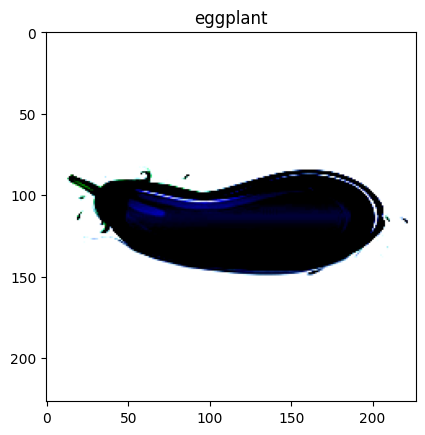

In [16]:
image, label = trainset[22]

class_list = ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute((1,2,0)))
plt.title(class_list[label])

In [14]:
print(f"No. of examples in the trainset {len(trainset)}")
print(f"No. of examples in the validset {len(validset)}")

No. of examples in the trainset 148
No. of examples in the validset 38


# Load Dataset into Batches

In [17]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [18]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [19]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

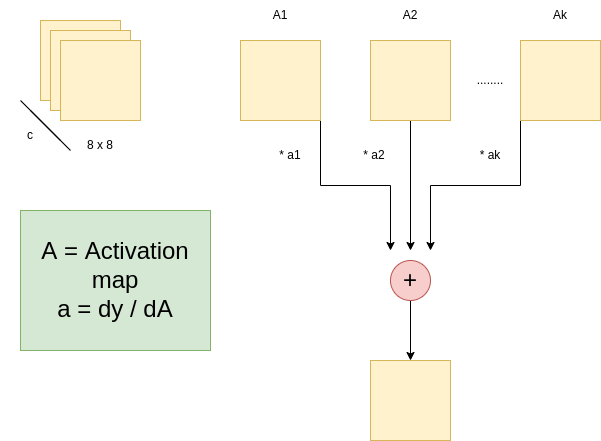

In [33]:
class ImageModel(nn.Module):
  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=1),
        nn.ReLU(),
    )

    self.maxpool = nn.MaxPool2d(kernel_size=(4,4), stride=2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048,3)
    )

    self.gradient = None

  def activation_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images) # activation map

    h = x.register_hook(self.activation_hook)

    x = self.maxpool(x)
    x = self.classifier(x)

    return x

  def get_activation_gradients(self): # a1, a2,...,ak
    return self.gradient

  def get_activation(self, x): # A1, A2, A3,...,Ak
    return self.feature_extractor(x) #64,8,8

In [34]:
model = ImageModel().to(DEVICE)
model

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [35]:
def train_fn(dataloader, model, optimizer, criterion):

  model.train()
  total_loss = 0
  for images, labels in tqdm(dataloader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [36]:
def eval_fn(dataloader, model, criterion):

  model.eval()
  total_loss = 0
  for images, labels in tqdm(dataloader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits = model(images)
    loss = criterion(logits, labels)
    total_loss += loss.item()

  return total_loss / len(dataloader)

# Training Loop

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [38]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  print(EPOCHS+1)

  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print("Saved weights successfully")

  print(f"TRAIN LOSS: {train_loss}, VALID LOSS: {valid_loss}")

21


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Saved weights successfully
TRAIN LOSS: 1.0554919481277465, VALID LOSS: 0.9285778800646464
21


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Saved weights successfully
TRAIN LOSS: 0.7108651041984558, VALID LOSS: 0.43738310039043427
21


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Saved weights successfully
TRAIN LOSS: 0.33887894824147224, VALID LOSS: 0.4246542975306511
21


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


TRAIN LOSS: 0.5098756611347198, VALID LOSS: 0.8135819335778555
21


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


TRAIN LOSS: 0.440588453412056, VALID LOSS: 0.4511784960826238
21


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Saved weights successfully
TRAIN LOSS: 0.1958583690226078, VALID LOSS: 0.1694272259871165
21


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS: 0.06391241913661361, VALID LOSS: 0.6901694224216044
21


100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


TRAIN LOSS: 0.13954100995324553, VALID LOSS: 1.079534689585368
21


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


TRAIN LOSS: 0.3678989043983165, VALID LOSS: 0.17167562743028006
21


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Saved weights successfully
TRAIN LOSS: 0.15576157406903804, VALID LOSS: 0.1332769269744555
21


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


TRAIN LOSS: 0.18458487931638956, VALID LOSS: 0.21309630196386328
21


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


TRAIN LOSS: 0.29372061789035797, VALID LOSS: 1.5765079061190288
21


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


TRAIN LOSS: 0.5442612403072417, VALID LOSS: 0.5566599567731222
21


100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


TRAIN LOSS: 0.23909624558873474, VALID LOSS: 0.1347635913019379
21


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


TRAIN LOSS: 0.06099464492872357, VALID LOSS: 0.43545143480878323
21


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


TRAIN LOSS: 0.06172302613340434, VALID LOSS: 0.4723348962531115
21


100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


TRAIN LOSS: 0.12486099665984511, VALID LOSS: 0.4227703586220741
21


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


TRAIN LOSS: 0.19020389448851346, VALID LOSS: 0.32018648087978363
21


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


TRAIN LOSS: 0.09521915912628173, VALID LOSS: 0.17298295092768967
21


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


TRAIN LOSS: 0.04709912110120058, VALID LOSS: 0.26902256067842245


# Get GradCAM

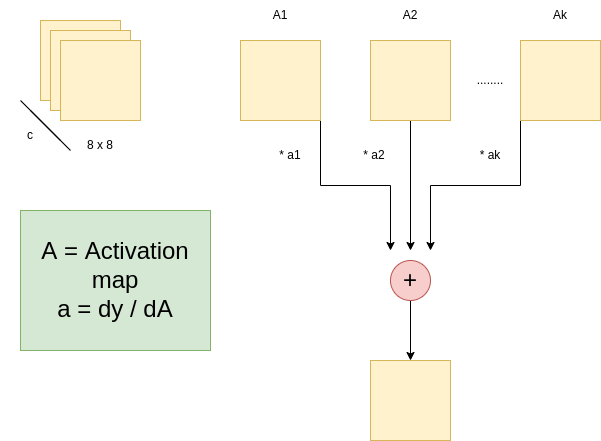

In [39]:
def get_grad_cam(model, image, label, size):

  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim=(0,2,3)) #a1,a2,...,ak
  activations = model.get_activation(image).detach() #A1, A2,...,Ak

  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim=1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size,size))

  return heatmap

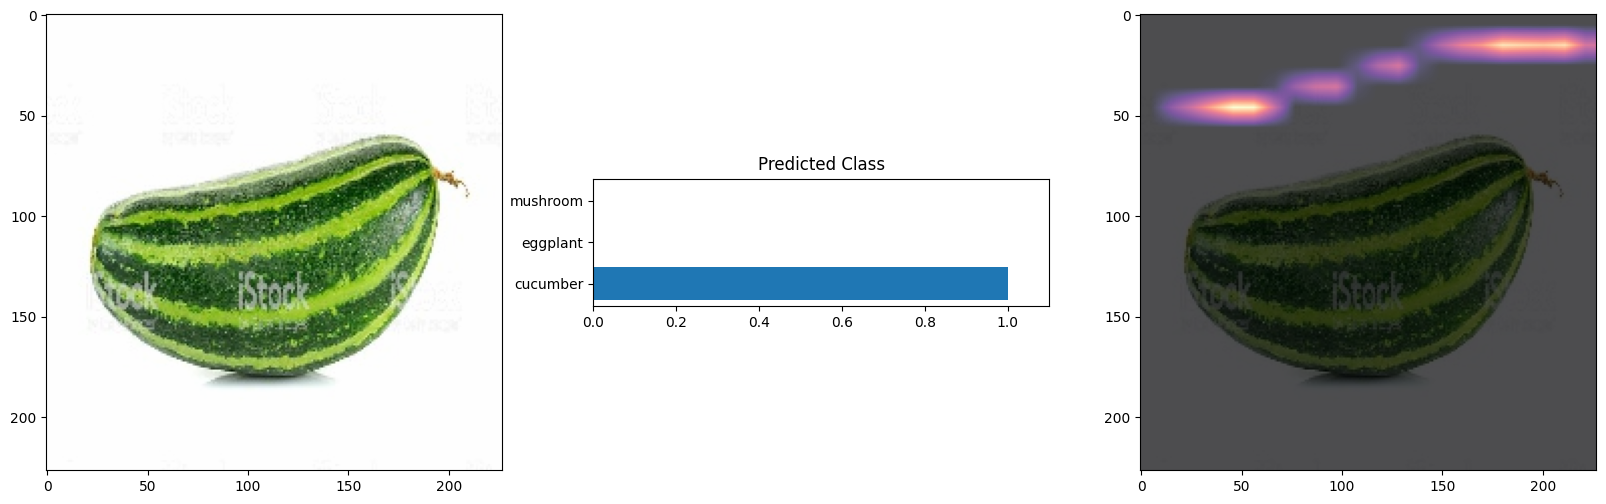

In [42]:
image, label = validset[22]

denorm_image = image.permute(1,2,0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_grad_cam(model, image, pred[0][1], size=227)
utils.plot_heatmap(denorm_image, pred, heatmap)